# Image Resolution Enhancement untuk Data Pemain Sepak Bola Indonesia dengan Vision Transformer

* 222101412 - Timothy Rudolf Tan (IBDA)

* 222200141 - Maxi Aditya Kusuma Winarjo (IBDA)

## Pustaka & fungsi utilitas

In [40]:
import os
from glob import glob
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shutil
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

In [41]:
def img_show_multiple(images: list[np.array], subplot_count: int, subplot_w: int, subplot_h: int, width: int, height: int, title="Image", subtitles=[]):
    # Create a figure and a grid of 24 subplots
    fig, axs = plt.subplots(subplot_h, subplot_w, figsize=(width, height))
    fig.suptitle(title)

    image_index = 0
    for index, ax in enumerate(axs.flat):
        if index < subplot_count:
            image = images[image_index]
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.imshow(image_rgb)
            ax.set_axis_off()  # turn off axis labels
            if len(subtitles) > 0:
                ax.set_title(subtitles[image_index])
            image_index += 1
        else:  # any remaining subplot shall stay hidden
            ax.set_visible(False)

    fig.tight_layout()
    fig.subplots_adjust(wspace=1, hspace=1)
    plt.show()  # show all the subplots

In [42]:
def img_show(image: np.array, width: int, height: int, title="Image") -> None:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(image_rgb)
    ax.set_title(title)
    ax.set_axis_off()

In [43]:
random.seed(50)

## I - Latar belakang

Dengan sekitar 250 juta pemain aktif yang tersebar di lebih dari 200 negara, tidak mengherankan bila sepak bola disemati julukan sebagai "bahasa universal" umat manusia. Di seluruh dunia, figur-figur pemain sepak bola menjadi fokus apresiasi para fans atau penggemar, yang tak jarang rela mengambil cuti kerja demi menghadiri langsung pertandingan tim favorit mereka. Sepak bola namun tidak sekadar menjadi hal yang penting bagi mereka yang mampu hadir langsung di stadium saja—miliaran penggemar sepak bola menghabiskan waktu menonton siaran langsung ataupun ulang di TV maupun digital streaming setiap harinya.

Salah satu aspek yang cukup menarik untuk disoroti perihal fenomena fans ini adalah maraknya fan account sepak bola di media sosial. Akun-akun fan termasif di Instagram, misalnya, lumrah mencapai lebih dari sejuta total pengikut (follower). Memanfaatkan fakta bahwa permainan sepak bola dewasa ini disiarkan di berbagai media dengan resolusi tinggi, para pengelola fan account lazim mem-post foto-foto highlight yang menyoroti aksi ulet para pemain terfavorit.

Untuk mendapatkan foto berkualitas pemain yang diinginkan, tentu menjadi tantangan tersendiri bagi para pengelola akun fan. Tidak jarang sebagian terpaksa menggunakan foto dengan kualitas rendah, seperti ini contohnya:

![Football Player (Low Quality)](burik.png)

Maka itu, dalam proyek kali ini kami hendak meneliti performa suatu model deep learning (secara khusus yang berbasis arsitektur modern ViT / vision transformer) dalam melakukan image resolution enhancement. Dengan kemampuannya untuk menangkap ketergantungan jarak jauh dan pola rumit dalam gambar, ViT menjadi opsi menarik untuk task memperbaiki gambar beresolusi rendah menjadi beresolusi tinggi.

## II - Dataset

Dalam proyek ini, kami menggunakan kumpulan data yang terdiri dari sekitar 1.000 gambar pemain sepak bola, diambil dari web.

Adapun data kami bagi menjadi tiga set berbeda: 80% untuk pelatihan, 10% untuk validasi, dan 10% untuk pengujian.

### Strukturisasi direktori

* Kita susun dataset ke dalam struktur direktori berikut:

```
data/
├── train/
│   ├── low_res/
│   └── high_res/
├── test/
│   ├── low_res/
│   └── high_res/
└── val/
    ├── low_res/
    └── high_res/
```

In [44]:
def create_partition_ranges(total):
    total -= 1
    
    # Calculate partition indices
    first_80_percent = int(total * 0.8)
    next_10_percent = int(total * 0.1)
    
    # Create range objects
    range_80 = range(0, first_80_percent)  # First 80%
    range_10_a = range(first_80_percent, first_80_percent + next_10_percent)  # Next 10%
    range_10_b = range(first_80_percent + next_10_percent, total)  # Last 10%
    
    return range_80, range_10_a, range_10_b


In [45]:
def pad_zeros(max_value):
    """
    Given an integer, return a string with up to 4 zeroes padded to the left.
    For example, 3 becomes 00003, while 280 becomes 00280.
    """

    if max_value >= 99999:
        raise ValueError("max_value should be less than 9999")
    return f"{max_value:05d}"


In [46]:
high_res_files = list(Path(".").rglob("HighRes/*/*"))
random.shuffle(high_res_files)  # shuffle the data (random seed was used)

N = len(high_res_files)
train_range, val_range, test_range = create_partition_ranges(N)
print(f"There are {N} high res files available.")

current_directory = os.getcwd()
dir_path = os.path.join(current_directory, "data")


There are 1322 high res files available.


In [47]:
# Recreate or create folder 'data'
if os.path.exists(dir_path):
    print(f"Folder 'data' already exists. Clearing contents...")
    shutil.rmtree(dir_path)  # Remove everything in the folder
else:
    print(f"Folder 'data' does not exist. Creating...")
os.makedirs(dir_path)

# Create subfolders
subdirs = ['train', 'val', 'test']
for subdir in subdirs:
    subdir_path = os.path.join(dir_path, subdir)
    os.makedirs(subdir_path, exist_ok=True)  # Create if it doesn't exist
    
    for quality in ['low_res', 'high_res']:
        quality_subdir_path = os.path.join(subdir_path, quality)
        os.makedirs(quality_subdir_path, exist_ok=True)
        
# Process each image in the input folder
for i, file_path in enumerate(high_res_files):
    print(f"Opened! {i} {file_path}")
    
    img_folder = os.path.basename(os.path.dirname(file_path))
    img_name = os.path.basename(file_path)
    _, img_ext = os.path.splitext(img_name)
    
    try:
        with Image.open(file_path) as img:
            scale_factor = 0.5  # Downscale to 50%
            new_size = (int(img.width * scale_factor), int(img.height * scale_factor))
            img_resized = img.resize(new_size, Image.BICUBIC)  # bicubic downsampling
            
            if i in train_range:
                folder = "train"
            elif i in val_range:
                folder = "val"
            elif i in test_range:
                folder = "test"
            
            img.save(f"data/{folder}/high_res/{pad_zeros(i)}{img_ext}")
            img_resized.save(f"data/{folder}/low_res/{pad_zeros(i)}{img_ext}")
            
            print(f"Saved! {i} {file_path}")
    except Exception as e:
        print(f"Failed to open file! {e}")
            

Folder 'data' already exists. Clearing contents...
Opened! 0 HighRes\KevinDiks\KevinDiks_23.jpeg
Saved! 0 HighRes\KevinDiks\KevinDiks_23.jpeg
Opened! 1 HighRes\IvarJenner\ivar-jenner_43.jpeg
Saved! 1 HighRes\IvarJenner\ivar-jenner_43.jpeg
Opened! 2 HighRes\ElkanBaggott\ElkanBaggott_256.jpeg
Saved! 2 HighRes\ElkanBaggott\ElkanBaggott_256.jpeg
Opened! 3 HighRes\ArkhanFikri\ArkhanFikri_171.jpeg
Saved! 3 HighRes\ArkhanFikri\ArkhanFikri_171.jpeg
Opened! 4 HighRes\AndySetyo\AndySetyo_35b.jpeg
Saved! 4 HighRes\AndySetyo\AndySetyo_35b.jpeg
Opened! 5 HighRes\AndySetyo\AndySetyo_1b6.jpeg
Saved! 5 HighRes\AndySetyo\AndySetyo_1b6.jpeg
Opened! 6 HighRes\ArkhanFikri\ArkhanFikri_2e4.jpeg
Saved! 6 HighRes\ArkhanFikri\ArkhanFikri_2e4.jpeg
Opened! 7 HighRes\RagnarOratmangoen\RagnarOratmangoen_179.jpeg
Saved! 7 HighRes\RagnarOratmangoen\RagnarOratmangoen_179.jpeg
Opened! 8 HighRes\AdamAlis\AdamAlis_264.jpeg
Saved! 8 HighRes\AdamAlis\AdamAlis_264.jpeg
Opened! 9 HighRes\EdoFebriansyah\edo-febriansyah-akui-

Setiap gambar beresolusi tinggi asli dipasangkan dengan gambar beresolusi rendah yang sesuai yang telah diproses menggunakan interpolasi bilinear. Pasangan ini memungkinkan kami untuk melatih dan mengevaluasi model peningkatan resolusi gambar kami secara efektif, dengan referensi yang jelas untuk output berkualitas tinggi yang diharapkan.

In [48]:
class EnhancementDataset(Dataset):
    def __init__(self, set: str, low_res_size=(256, 256), high_res_size=(1024, 1024)):
        if set == "train":
            high_res_files = Path(".").rglob("*train/*high_res/*.*")
            low_res_files = Path(".").rglob("*train/*low_res/*.*")

        elif set == "val":
            high_res_files = Path(".").rglob("*val/*high_res/*.*")
            low_res_files = Path(".").rglob("*val/*low_res/*.*")

        elif set == "test":
            high_res_files = Path(".").rglob("*test/*high_res/*.*")
            low_res_files = Path(".").rglob("*test/*low_res/*.*")

        self.low_res_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(low_res_size)
        ])
        self.high_res_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(high_res_size)
        ])
        
        # Create pairs of low-res and high-res files
        self.image_pairs = []
        for high_res_file, low_res_file in zip(high_res_files, low_res_files):
            base_name = os.path.basename(high_res_file)
            name, ext = os.path.splitext(base_name)
            # low_res_file = os.path.join(low_res_dir, f"{name}x2{ext}")
            if os.path.exists(low_res_file):
                self.image_pairs.append((low_res_file, high_res_file))

        print(f"Found {len(self.image_pairs)} image pairs in the {set} set.")

    def __len__(self):
        return len(self.image_pairs)
    
    def __getitem__(self, index):
        low_res_path, high_res_path = self.image_pairs[index]
        
        try:
            low_res_img = Image.open(low_res_path).convert('RGB')
            high_res_img = Image.open(high_res_path).convert('RGB')
        except IOError as e:
            print(f"Error opening image files: {e}")
            # Skip to the next item if possible
            if index + 1 < len(self):
                return self.__getitem__(index + 1)
            else:
                raise IOError(f"No valid image pair found for index {index}")
        
        # Apply transformations
        low_res_tensor = self.low_res_transform(low_res_img)
        high_res_tensor = self.high_res_transform(high_res_img)
        
        return low_res_tensor, high_res_tensor

### Seleksi sampel

In [49]:
img_a = "data/train/high_res/00001.jpeg"
img_a = cv2.imread(img_a, cv2.IMREAD_COLOR)

img_b = "data/train/low_res/00001.jpeg"
img_b = cv2.imread(img_b, cv2.IMREAD_COLOR)

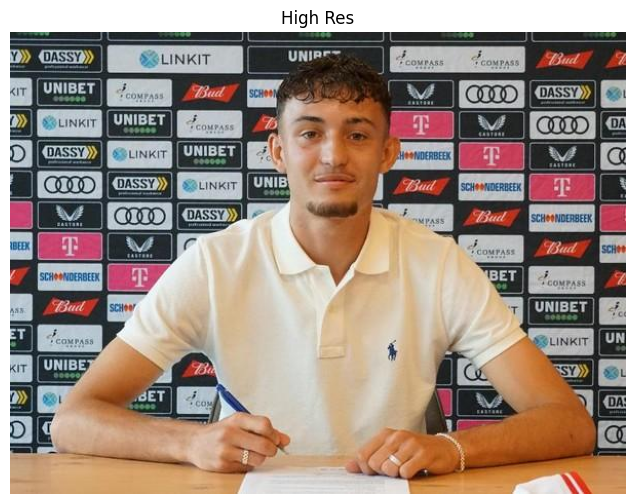

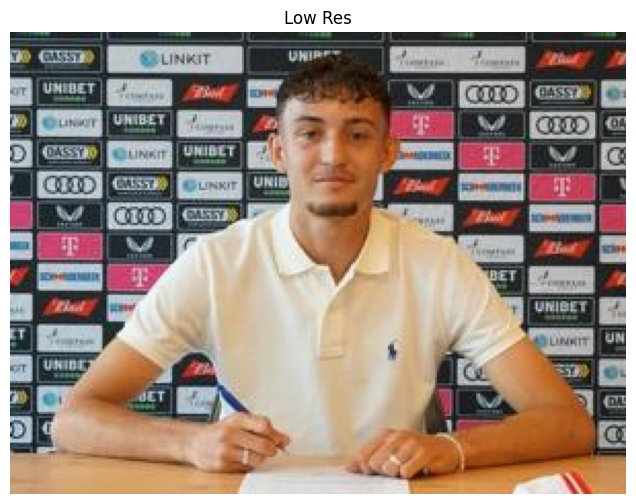

In [50]:
img_show(img_a, 10, 6, "High Res")

img_show(img_b, 10, 6, "Low Res")

## III - Pelatihan

Proses pelatihan pun bisa dimulai, dengan training set 80% dan test set 10%.

In [51]:
class BalancedEnhancementLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3):
        super().__init__()
        self.mse = nn.MSELoss()
        self.alpha = alpha
        self.alpha = alpha
        self.beta = beta

    def forward(self, enhanced, high_res):
        mse_loss = self.mse(enhanced, high_res)
        enhancement_loss = 1.0 / (psnr(enhanced, high_res) + 1e-8)
        return self.alpha * mse_loss + self.beta * enhancement_loss

def adjust_loss_weights(epoch, total_epochs):
    alpha = 1.0 - (epoch / total_epochs) * 0.3
    beta = (epoch / total_epochs) * 0.3
    return alpha, beta

def psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse + 1e-8))

In [52]:
def train_model(model, train_loader, val_loader, num_epochs=50, device='cpu'):
    model = model.to(device)
    criterion = BalancedEnhancementLoss()
    optimizer = Adam(model.parameters(), lr=1e-6)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        alpha, beta = adjust_loss_weights(epoch, num_epochs)
        criterion.alpha, criterion.beta = alpha, beta

        for batch_idx, (low_res, high_res) in tqdm(enumerate(train_loader)):
            low_res, high_res = low_res.to(device), high_res.to(device)
            
            optimizer.zero_grad()
            enhanced = model(low_res)
            loss = criterion(enhanced, high_res)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss = validate_model(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model, train_losses, val_losses

def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for low_res, high_res in val_loader:
            low_res, high_res = low_res.to(device), high_res.to(device)
            enhanced = model(low_res)
            loss = criterion(enhanced, high_res)
            val_loss += loss.item()
    return val_loss / len(val_loader)

### Hyperparameter

In [53]:
batch_size = 8
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data

In [54]:
train_dataset = EnhancementDataset('train')
val_dataset = EnhancementDataset('val')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Found 1056 image pairs in the train set.
Found 132 image pairs in the val set.


### Model

*Disclaimer:* Kami kesulitan dalam menemukan model VIT pre-trained untuk image enhancement; model yang kami gunakan ini di-*train* dari awal, dengan implementasi arsitektur transformer *imhance*.

https://github.com/bcivitcioglu/imhance/

In [55]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.w_q = nn.Linear(embed_dim,embed_dim,bias=False)
        self.w_k = nn.Linear(embed_dim,embed_dim,bias=False)
        self.w_v = nn.Linear(embed_dim,embed_dim,bias=False)

        self.w_out = nn.Linear(embed_dim, embed_dim, bias=False)

    def forward(self, x):
        (batch_size, num_patches, embed_dim) = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q = q.reshape(batch_size, num_patches, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.reshape(batch_size, num_patches, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.reshape(batch_size, num_patches, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attention = torch.matmul(q,k.transpose(-2,-1)) * self.head_dim ** -0.5
        attention_prob = torch.softmax(attention,dim=-1)
        attention_out = torch.matmul(attention_prob, v)
        attention_out = attention_out.permute(0, 2, 1, 3).reshape(batch_size, num_patches, embed_dim)
        output = self.w_out(attention_out)

        return output


In [56]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim=2048):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.multi_head_att = MultiHeadAttention(
            embed_dim=self.embed_dim, num_heads=self.num_heads
        )

        # FFN
        self.ff_network = nn.Sequential(
            nn.Linear(embed_dim, ff_dim), nn.ReLU(), nn.Linear(ff_dim, embed_dim)
        )

        # Layer normalization to normalize the values of the inputs across the features
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        norm1 = self.norm1(x)
        attn_output = self.multi_head_att(norm1)
        x = x + attn_output
        norm2 = self.norm2(x)
        ff_output = self.ff_network(norm2)
        x = x + ff_output

        return x


class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        encoder_list = [
            TransformerEncoderBlock(embed_dim=self.embed_dim, num_heads=self.num_heads)
            for _ in range(num_layers)
        ]
        self.encoder = nn.ModuleList(encoder_list)

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
        return x

In [57]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size : tuple, patch_size, embed_dim, in_channels = 3):
        super().__init__()
        self.img_height, self.img_width = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        # Calculate the number of patches 
        self.num_patches_h = self.img_height // self.patch_size
        self.num_patches_w = self.img_width // self.patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        
        # Effective image size 
        self.effective_h = self.num_patches_h * self.patch_size
        self.effective_w = self.num_patches_w * self.patch_size
        
        # Patch embedding layer
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.rand(1, self.num_patches , embed_dim)*0.02)

    def forward(self, batch_imgs: torch.Tensor):
        assert batch_imgs.dim() == 4, "Expecting batch of images with the shape (BATCH, CHANNEL, HEIGHT, WIDTH)"
        in_batch_size, in_chn, in_h, in_w = batch_imgs.shape
        assert (in_h == self.effective_h and in_w == self.effective_w), f"Input image shape must be ({self.effective_h}, {self.effective_w}) but given ({in_h,in_w})"
        
        # Apply patch embedding
        patch_embedded_image = self.patch_embed(batch_imgs)  # shape: (batch_size, embed_dim, height/patch_size, width/patch_size)
        
        # Reshape to sequence of patches
        patch_sequence_image = patch_embedded_image.flatten(2).transpose(1, 2)
        
        # Add positional embedding
        patch_sequence_image += self.pos_embed
        
        return patch_sequence_image
    

In [58]:
class ImageEnhanceTransformer(nn.Module):
    def __init__(
        self,
        image_size: tuple,
        patch_size,
        embed_dim,
        num_layers,
        num_heads,
        output_size: tuple,
        in_channels=3,
    ):
        super().__init__()

        self.img_height, self.img_width = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.num_layers = num_layers
        self.num_heads = num_heads
        self.out_height, self.out_width = output_size
        self.in_channels = in_channels

        self.patch_embed = PatchEmbedding(
            (self.img_height, self.img_width),
            self.patch_size,
            self.embed_dim,
            self.in_channels,
        )

        assert (
            self.img_height == self.patch_embed.effective_h
        ), "Image height doesn't match effective height"
        assert (
            self.img_width == self.patch_embed.effective_w
        ), "Image width doesn't match effective width"

        self.encoder = TransformerEncoder(
            self.num_layers, self.embed_dim, self.num_heads
        )

        self.num_patches_h = self.patch_embed.num_patches_h
        self.num_patches_w = self.patch_embed.num_patches_w
        self.num_patches = self.patch_embed.num_patches

        self.upscale_factor = output_size[0] // image_size[0]
        self.output_patch_size = patch_size * self.upscale_factor

        self.to_patch = nn.Linear(
            self.embed_dim,
            self.output_patch_size * self.output_patch_size * self.in_channels,
        )

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.to_patch(x)

        batch_size = x.shape[0]

        x = x.view(
            batch_size,
            self.num_patches_h,
            self.num_patches_w,
            self.output_patch_size,
            self.output_patch_size,
            self.in_channels,
        )
        x = x.permute(0, 5, 1, 3, 2, 4).contiguous()
        x = x.view(batch_size, self.in_channels, self.out_height, self.out_width)

        return x

In [59]:
model = ImageEnhanceTransformer(
    image_size=(256, 256),
    patch_size=16,
    embed_dim=256,
    num_layers=6,
    num_heads=8,
    output_size=(1024, 1024)
)

TRAIN = True

if TRAIN:
    print("Beginning the training...")
    trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, device)
else:
    trained_model = model

Beginning the training...


132it [00:24,  5.28it/s]


Epoch 1/20, Train Loss: 0.4621, Val Loss: 0.3347


132it [00:24,  5.31it/s]


Epoch 2/20, Train Loss: 0.3187, Val Loss: 0.2918


132it [00:24,  5.30it/s]


Epoch 3/20, Train Loss: 0.2946, Val Loss: 0.2784


132it [00:25,  5.28it/s]


Epoch 4/20, Train Loss: 0.2834, Val Loss: 0.2694


132it [00:24,  5.28it/s]


Epoch 5/20, Train Loss: 0.2747, Val Loss: 0.2615


132it [00:24,  5.50it/s]


Epoch 6/20, Train Loss: 0.2663, Val Loss: 0.2532


132it [00:24,  5.35it/s]


Epoch 7/20, Train Loss: 0.2574, Val Loss: 0.2443


132it [00:24,  5.45it/s]


Epoch 8/20, Train Loss: 0.2479, Val Loss: 0.2348


132it [00:24,  5.38it/s]


Epoch 9/20, Train Loss: 0.2375, Val Loss: 0.2245


132it [00:29,  4.50it/s]


Epoch 10/20, Train Loss: 0.2266, Val Loss: 0.2138


132it [00:24,  5.36it/s]


Epoch 11/20, Train Loss: 0.2152, Val Loss: 0.2028


132it [00:24,  5.37it/s]


Epoch 12/20, Train Loss: 0.2037, Val Loss: 0.1917


132it [00:24,  5.29it/s]


Epoch 13/20, Train Loss: 0.1922, Val Loss: 0.1808


132it [00:24,  5.31it/s]


Epoch 14/20, Train Loss: 0.1809, Val Loss: 0.1702


132it [00:25,  5.11it/s]


Epoch 15/20, Train Loss: 0.1700, Val Loss: 0.1599


132it [00:24,  5.33it/s]


Epoch 16/20, Train Loss: 0.1595, Val Loss: 0.1501


132it [00:25,  5.25it/s]


Epoch 17/20, Train Loss: 0.1496, Val Loss: 0.1408


132it [00:25,  5.13it/s]


Epoch 18/20, Train Loss: 0.1402, Val Loss: 0.1322


132it [00:25,  5.18it/s]


Epoch 19/20, Train Loss: 0.1314, Val Loss: 0.1240


132it [00:24,  5.30it/s]


Epoch 20/20, Train Loss: 0.1232, Val Loss: 0.1164


Model kita simpan supaya bisa digunakan kembali (tanpa perlu melewati keseluruhan proses pelatihan lagi).

In [60]:
if TRAIN:
    torch.save(trained_model.state_dict(), 'trained_model.pth')

### Losses

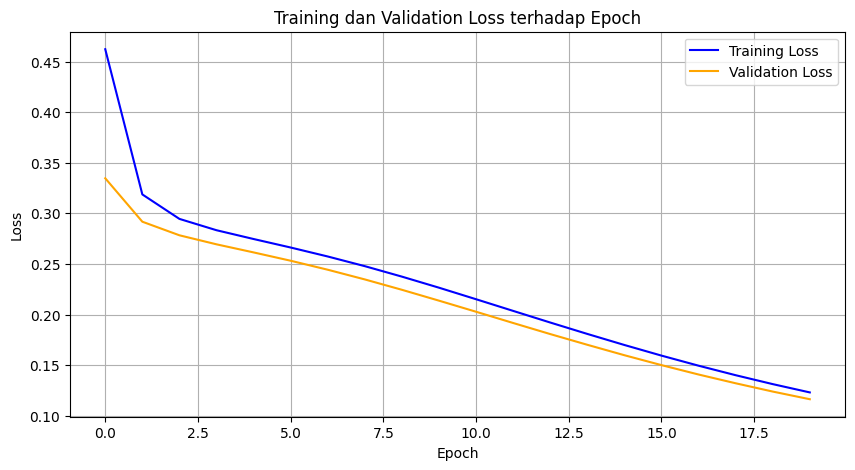

In [61]:
if TRAIN:
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training dan Validation Loss terhadap Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [62]:
if not TRAIN:
    state_dict = torch.load('trained_model.pth')
    trained_model.load_state_dict(state_dict)

## IV - Evaluasi

### Peak Signal-to-Noise Ratio (PSNR)

Untuk menilai kinerja model kami secara objektif, kami menggunakan Peak Signal-to-Noise Ratio (PSNR) sebagai metrik evaluasi. Adapun PSNR merupakan metrik umum dalam image enhancement; nilai PSNR yang lebih tinggi menunjukkan fidelitas yang lebih baik&mdash;antara gambar rekonstruksi denga gambar asli beresolusi tinggi.

$$
\text{PSNR} = 10 \cdot \log_{10} \left( \frac{MAX_I^2}{MSE} \right)
$$

di mana:
- $MAX_I$ adalah nilai pixel maksimum yang mungkin pada gambar;
- $MSE$ (Mean Squared Error), dihitung dengan:

$$
MSE = \frac{1}{N} \sum_{i=1}^{N} \left( I_{original}(i) - I_{enhanced}(i) \right)^2
$$

yang, dalam hal ini mencakup:
- $I_{original}(i)$: nilai pixel pada gambar semula di pixel ke-$i$;
- $I_{enhanced}(i)$: nilai pixel pada gambar rekonstruksi di pixel ke-$i$;
- $N$: total pixel pada gambar.


In [63]:
def calculate_psnr(original, enhanced):
    """
    Calculate PSNR between original and enhanced images.
    """

    mse = np.mean((original - enhanced) ** 2)
    if mse == 0:
        return float('inf')  # PSNR is infinite for identical images
    max_pixel_value = 255.0  # Assuming the pixel values are in the range [0, 255]
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    
    return psnr

In [64]:
def evaluate_model(model, test_loader, device):
    model = model.to(device)
    model.eval()
    psnr_values = []

    with torch.no_grad():
        for low_res, high_res in test_loader:
            low_res = low_res.to(device)
            high_res = high_res.to(device)

            # Generate enhanced images
            enhanced = model(low_res)

            # Convert tensors to NumPy arrays for PSNR calculation
            enhanced_np = enhanced.cpu().numpy().squeeze(0)  # Remove batch dimension
            high_res_np = high_res.cpu().numpy().squeeze(0)  # Remove batch dimension
            
            # Convert from [0, 1] range (if using ToTensor) to [0, 255] range for PSNR
            enhanced_np = np.clip(enhanced_np * 255, 0, 255).astype(np.uint8)
            high_res_np = np.clip(high_res_np * 255, 0, 255).astype(np.uint8)

            # Calculate PSNR for each image in the batch
            psnr = calculate_psnr(high_res_np, enhanced_np)
            psnr_values.append(psnr)

    df_psnr = pd.DataFrame({'psnr': psnr_values})

    # average_psnr = np.mean(psnr_values)
    # print(f'Average PSNR: {average_psnr:.2f} dB')

    return df_psnr

Berikut ini evaluasi model kami test set 10 digunakan.

In [65]:
test_dataset = EnhancementDataset('test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Found 134 image pairs in the test set.


In [66]:
df_psnr = evaluate_model(trained_model, test_loader, device)

In [67]:
df_psnr.head()

,psnr
0,28.007703
1,28.204419
2,27.935989
3,28.043696
4,28.333410


In [68]:
df_psnr.describe()

,psnr
count,134.000000
mean,28.017352
std,0.131680
min,27.817171
25%,27.941202
50%,27.984103
75%,28.049860
max,28.740125


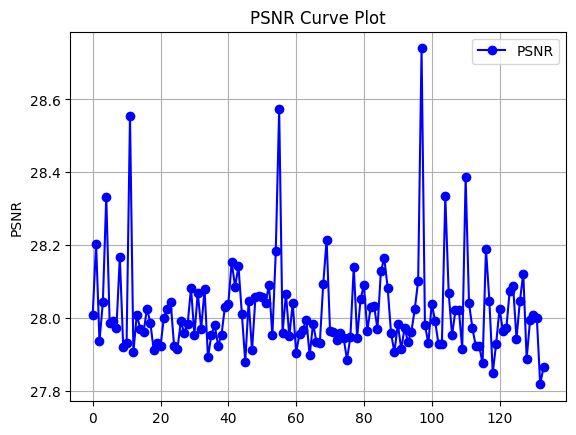

In [69]:
plt.plot(df_psnr.index, df_psnr['psnr'], marker='o', linestyle='-', color='b', label='PSNR')
plt.xlabel('')
plt.ylabel('PSNR')
plt.title('PSNR Curve Plot')
plt.legend()
plt.grid(True)
plt.show()

## V - Kesimpulan

Dalam proyek ini, kami melatih model image resolution enhancement menggunakan arsitektur berbasis Vision Transformer. Model tersebut mampu merekonstruksi gambar beresolusi tinggi dari input beresolusi rendah, dengan rataan PSNR 28 dB, yang menunjukkan kualitas output semestinya cukup optimal.

# GitHub Repo Link

https://github.com/TimothyRT/uas-cv